### Krill Growth Model (Atkinson et al 2006)

#### This empirical model derives a Daily Growth Rate (DGR, mm $d^{-1}$) from a starting length of an individual krill, chlorophyll concentration, and SST:

$DGR = a + b * Length + c * Length^2 + [d * \frac{CHL}{e + CHL}] + f * SST + g * SST ^2$

- Length (L mm) = Proxy for growth =  using 40mm as the starting value (observed mean length of adult krill)
- SST (°C) = Proxy for survival =  threshold between -1 to 5°C
- Chl-a (mg m$^{-3}$) = Proxy for food availability - threshold: 0.5 mg m-3

Murphy et al 2017:
<blockquote> Sensitivity of the empirical model: Optimum growth rates vary with animal size, but occur generally between temperatures -1 to 2 o C and chlorophyll a concentrations > 1.0 mg m-3  (Figure S3). For chlorophyll a concentrations >1.0 mg m$^{-3}$ there is little change in the potential rate of growth, but the model is particularly sensitive to the change in chlorophyll a concentration from < 0.1 mg m$^{-3}$ to > 1 mg chl a m$^{-3}$ (Figure S34 ). Above ~1°C growth rates decline and this is particularly rapid above ~2°C and also below ~ -1°C. </blockquote>

___
### Objective: estimate the growth potential for each 1° by 1° latitude-longitude grid cell for each month (mm month−1)
Murphy et al: estimated potential growth from satelitte data

From Murphy et al 2017: used Atkinson et al. 2006; Model 3; see their Table 5
<blockquote> Growth potential was calculated in two ways. In the first we calculated growth rates for each month only for months and cells where both SST and chlorophyll a values were present. In the second calculation for the months and locations where SST data were available but chlorophyll data were missing, we assumed the chlorophyll a concentration was 0.0 mg m−3 . Area-weighted mean growth rates were derived to generate summary estimates of circumpolar mean monthly growth rates (September to April; May to August were excluded because of extensive missing data due to cloud and sea ice cover). </blockquote>

Devi et al: Evaluated projected changes in krill habitat between the recent past (1960-1989) and end of the century (2070-2099).

* simulated growth potential as a measure of habitat quality
* growth potential method from murphy et al 
* Habitat area = the surface area of grid cells where growth potential was positive
* all growth potential calculations were done using seasonal climatologies yeilding seasonal GP AND YET:
* For each day in the season, DGR was calculated using the SST and chlorophyll fields, and then added to the previous length.

From Devi: 
<blockquote> if SST was present and chlorophyll was absent, then chlorophyll was set to 0 mg m-3 , whereas if there was sea ice cover the cell was excluded from the calculation. </blockquote>

<blockquote>Although previous analyses have included other starting size classes, we found that projected differences between future and historical epochs remained the same irrespective of starting length. For each day in the season, DGR was calculated using the SST and chlorophyll fields, and then added to the previous length</blockquote>

___
### Notebook Goal: 
#### write a function to calculate KGP in the same dimensions of an ensemble member:

example:

<code>def compute KGP(CHL, SST):
    return f(CHL) + g(SST)   
</code>
so that `KGP = compute_KGP(CHL, SST)` #inherits dims of chl and sst (member_id, time, nlat, nlon) and so that you can go further to do `KGP_SO = compute_areal_mean(KGP)` resulting in KGP_SO dims = m, t, region


In [4]:
#Import Modules
import os

import math
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
%matplotlib inline

In [5]:
# specify coefs
a = -0.066 # Constant - all krill combined (no life stage or sex)
b = 0.002 # Linear term relating to length
c = -0.000061 # Quadratic term relating to length
d = 0.385 # Maximum term relating to food
e = 0.328 # Half Saturation constant relating to food
f = 0.0078 # Linear term relating to temperature
g = -0.0101 # Quadratic term relating to temperature

In [39]:
#test conditions
temp = [-2,-1, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
#food = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3]
#food = [0, 0.06, 0.07, 0.1, 0.22, 0.38, 0.5, 0.7, 1, 1.3, 1.5, 1.78, 2, 3, 4, 5] 
food = [0, 0.04, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 1.3, 1.5, 1.78, 2, 3] 

long = [10, 15, 20, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 55, 60]
# intialise data of lists. 
data = {'SST': temp, 's': "",
        'CHL': food,'c': "",
        'L_i': long, 'l': ""} 
# Create DataFrame 
df = pd.DataFrame(data) 
# Calculate Tests on the data frame
df['s'] = np.round((f * df.SST + g * df.SST**2), 3)
df['c'] = np.round((d * df.CHL / (e + df.CHL)), 3)
df['l'] = np.round ((a + (b * df.L_i) + (c * df.L_i**2)), 3)
# Print the output. 
print('Example conditions and their resulting terms within the DGR Function:')
df.head()

Example conditions and their resulting terms within the DGR Function:


,SST,s,CHL,c,L_i,l
0,-2.00,-0.056,0.00,0.000,10.0,-0.052
1,-1.00,-0.018,0.04,0.042,15.0,-0.050
2,-0.50,-0.006,0.07,0.068,20.0,-0.050
3,-0.25,-0.003,0.10,0.090,25.0,-0.054
4,0.00,0.000,0.20,0.146,27.5,-0.057


In [41]:
df

,SST,s,CHL,c,L_i,l
0,-2.00,-0.056,0.00,0.000,10.0,-0.052
1,-1.00,-0.018,0.04,0.042,15.0,-0.050
2,-0.50,-0.006,0.07,0.068,20.0,-0.050
3,-0.25,-0.003,0.10,0.090,25.0,-0.054
4,0.00,0.000,0.20,0.146,27.5,-0.057
5,0.25,0.001,0.30,0.184,30.0,-0.061
6,0.50,0.001,0.40,0.212,32.5,-0.065
7,0.75,0.000,0.50,0.232,35.0,-0.071
8,1.00,-0.002,0.60,0.249,37.5,-0.077
9,1.50,-0.011,0.70,0.262,40.0,-0.084


In [9]:
from matplotlib import style
style.use('ggplot')

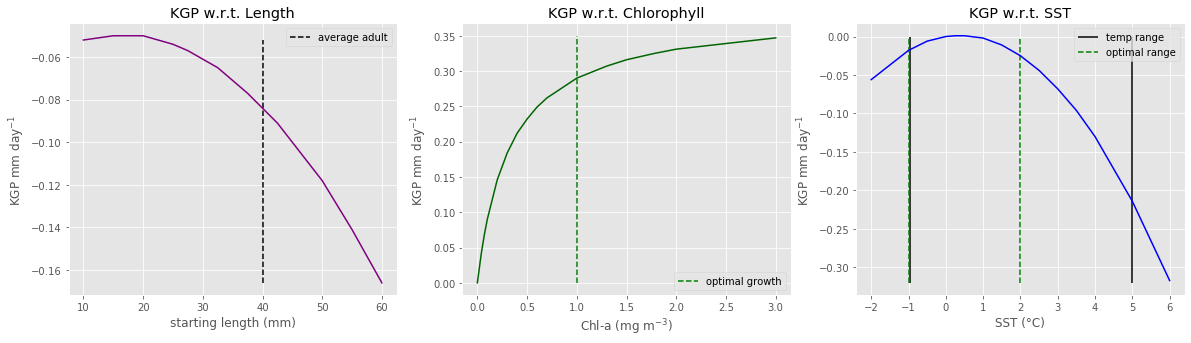

In [37]:
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(131)
ax1.set_title('KGP w.r.t. Length')
ax1.plot(df.L_i, df.l, color ='purple')
ax1.vlines(40, -0.166, -0.052 , color='black', linestyle = 'dashed', label = 'average adult')
plt.xlabel("starting length (mm)")
plt.ylabel("KGP mm day$^{-1}$")
plt.legend()
plt.gca();

ax2 = fig.add_subplot(132)
ax2.set_title('KGP w.r.t. Chlorophyll')
ax2.plot(df.CHL, df.c, color = 'darkgreen')
#ax2.vlines(0.5, 0, .35, color='red', linestyle = 'dashed', label = 'growth threshold')
ax2.vlines(1, 0, .35, color='green', linestyle = 'dashed', label = 'optimal growth')
plt.xlabel("Chl-a (mg m$^{-3}$)")
plt.ylabel("KGP mm day$^{-1}$")
plt.legend(loc = 'lower right')
plt.gca()

ax3 = fig.add_subplot(133)
ax3.set_title('KGP w.r.t. SST')
ax3.plot(df.SST, df.s, '-b')
ax3.vlines([-0.95,5], -0.32, 0 , color='black', linestyle = 'solid', label = 'temp range')
ax3.vlines([-1,2], -0.32, 0 , color='green', linestyle = 'dashed', label = 'optimal range')
plt.legend()
plt.xlabel("SST (°C)")
plt.ylabel("KGP mm day$^{-1}$")
plt.gca()

plt.savefig('KGP with respect to terms.png')

### Single Plots

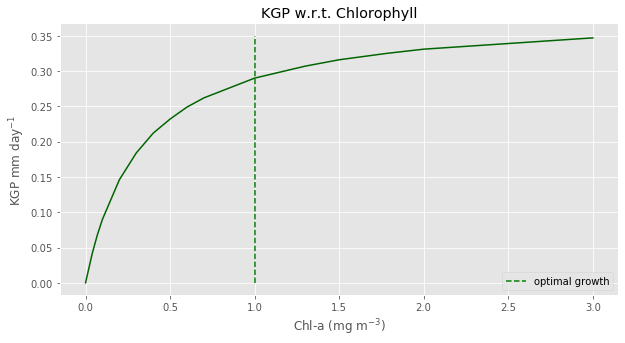

In [35]:
fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(111)
ax2.set_title('KGP w.r.t. Chlorophyll')
ax2.plot(df.CHL, df.c, color = 'darkgreen')
ax2.vlines(1, 0, .35, color='green', linestyle = 'dashed', label = 'optimal growth')
plt.xlabel("Chl-a (mg m$^{-3}$)")
plt.ylabel("KGP mm day$^{-1}$")
plt.legend(loc = 'lower right')
plt.gca()

plt.savefig('figures/KGP with respect to chl.png')

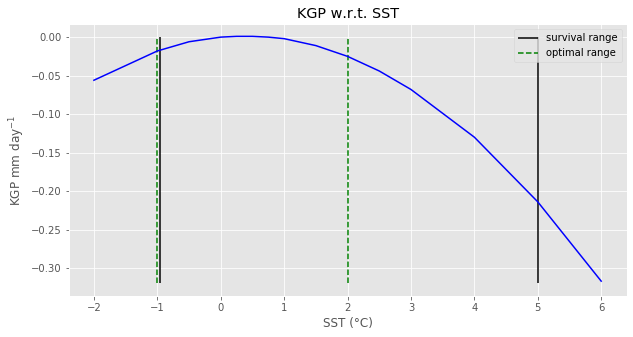

In [40]:
fig = plt.figure(figsize=(10,5))

ax3 = fig.add_subplot(111)
ax3.set_title('KGP w.r.t. SST')
ax3.plot(df.SST, df.s, '-b')
ax3.vlines([-0.95,5], -0.32, 0 , color='black', linestyle = 'solid', label = 'survival range')
ax3.vlines([-1,2], -0.32, 0 , color='green', linestyle = 'dashed', label = 'optimal range')                             
plt.legend()
plt.xlabel("SST (°C)")
plt.ylabel("KGP mm day$^{-1}$")
plt.gca()

plt.savefig('figures/KGP with respect to sst.png')

In [6]:
#test conditions
length = 40
sst = 1
chl = 1

#DGR Expression
length_term = a + (b * length) + (c * length**2)
chl_term = d * (chl / e + chl)
sst_term = f * sst + g * sst**2
print('length term:', np.round(length_term, 3)) 
print('chl term:', np.round(chl_term, 3))
print('sst term:', np.round(sst_term, 3))

DGR = length_term + chl_term + sst_term
print('DGR Test Case:', np.round(DGR,2))

length term: -0.084
chl term: 1.559
sst term: -0.002
DGR Test Case: 1.47
